# Лабораторная работа №11

Мультимодальное обучение: Vision Transformer и контрастное обучение изображений и текста (CLIP-подход)

In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import random

SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

DEVICE = "cuda" # На конец не на cpu) 
print("DEVICE:", DEVICE)

DEVICE: cuda


Подготовкадатасета

In [101]:
IMG_SIZE = 32
BATCH_SIZE = 64
NUM_CLASSES = 10

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.5, 0.5, 0.5),
        std=(0.5, 0.5, 0.5)
    )
])

train_ds = datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

test_ds = datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)

CLASS_NAMES = train_ds.classes
print("Classes:", CLASS_NAMES)

Files already downloaded and verified
Files already downloaded and verified
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Описание датасета

В качестве датасета для классификации изображений используется CIFAR-10.
Датасет содержит цветные изображения размером 32×32 пикселя,
разделённые на 10 классов. Для упрощения обучения применяется нормализация
изображений и формирование обучающей и тестовой выборок с использованием DataLoader.

In [ ]:

print("Dataset: CIFAR-10")
print("Train size:", len(train_ds))
print("Test size:", len(test_ds))
print("Image size:", train_ds[0][0].shape)
print("Number of classes:", len(CLASS_NAMES))
print("Classes:", CLASS_NAMES)

Dataset: CIFAR-10
Train size: 50000
Test size: 10000
Image size: torch.Size([3, 32, 32])
Number of classes: 10
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


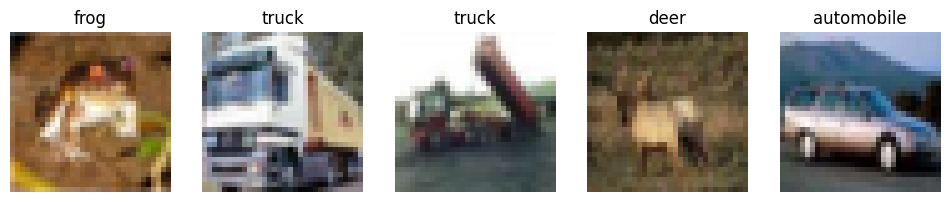

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 5, figsize=(12, 3))
for i in range(5):
    img, label = train_ds[i]
    axes[i].imshow(img.permute(1, 2, 0) * 0.5 + 0.5)
    axes[i].set_title(CLASS_NAMES[label])
    axes[i].axis("off")
plt.show()

Формирование патчей и входного представления Vit

In [ ]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, d_model):
        super().__init__()
        assert img_size % patch_size == 0

        self.num_patches = (img_size // patch_size) ** 2
        self.patch_size = patch_size

        self.proj = nn.Conv2d(
            in_channels,
            d_model,
            kernel_size=patch_size,
            stride=patch_size
        )

        self.cls_token = nn.Parameter(torch.zeros(1, 1, d_model))
        self.pos_embed = nn.Parameter(
            torch.zeros(1, self.num_patches + 1, d_model)
        )

    def forward(self, x):
        B = x.size(0)

        x = self.proj(x)                 # [B, d_model, H', W']
        x = x.flatten(2).transpose(1, 2) # [B, N, d_model]

        cls = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls, x], dim=1)

        return x + self.pos_embed

Многоголовое самовнимание (Multi-Head Self-Attention)

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0
        self.h = num_heads
        self.d = d_model // num_heads

        self.qkv = nn.Linear(d_model, d_model * 3)
        self.out = nn.Linear(d_model, d_model)

    def forward(self, x):
        B, T, C = x.shape

        qkv = self.qkv(x).reshape(B, T, 3, self.h, self.d)
        qkv = qkv.permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        scores = (q @ k.transpose(-2, -1)) / math.sqrt(self.d)
        attn = scores.softmax(dim=-1)

        out = (attn @ v).transpose(1, 2).reshape(B, T, C)
        return self.out(out)

## Transformer-блок как в лаб 10

In [ ]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, dim_ff):
        super().__init__()
        self.attn = MultiHeadAttention(d_model, num_heads)
        self.ff = nn.Sequential(
            nn.Linear(d_model, dim_ff),
            nn.ReLU(),
            nn.Linear(dim_ff, d_model)
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, x):
        x = self.norm1(x + self.attn(x))
        x = self.norm2(x + self.ff(x))
        return x

In [ ]:
class TransformerEncoder(nn.Module):
    def __init__(self, num_layers, d_model, num_heads, dim_ff):
        super().__init__()
        self.layers = nn.ModuleList([
            TransformerEncoderLayer(d_model, num_heads, dim_ff)
            for _ in range(num_layers)
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

Vit-классификатор

In [ ]:
class ViTClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.patch = PatchEmbedding(
            img_size=32,
            patch_size=4,
            in_channels=3,
            d_model=128
        )
        self.encoder = TransformerEncoder(
            num_layers=4,
            d_model=128,
            num_heads=4,
            dim_ff=256
        )
        self.fc = nn.Linear(128, NUM_CLASSES)

    def forward(self, x):
        x = self.patch(x)
        x = self.encoder(x)
        cls = x[:, 0]
        return self.fc(cls)

Обучение Vit

In [ ]:
model = ViTClassifier().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss()

In [ ]:
def train_epoch(loader):
    model.train()
    loss_sum = 0
    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        loss_sum += loss.item()
    return loss_sum / len(loader)

In [ ]:
def eval_model(loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            preds = model(x).argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return correct / total

In [ ]:
EPOCHS = 5
for e in range(EPOCHS):
    loss = train_epoch(train_loader)
    acc = eval_model(test_loader)
    print(f"Epoch {e+1}: loss={loss:.4f}, acc={acc:.4f}")

torch.save(model.state_dict(), "vit_classifier.pt")

Epoch 1: loss=1.6227, acc=0.5191
Epoch 2: loss=1.2206, acc=0.5719
Epoch 3: loss=1.0694, acc=0.6074
Epoch 4: loss=0.9659, acc=0.6280
Epoch 5: loss=0.8816, acc=0.6539


TextEncoder из 10 лабы 

In [ ]:
class TextEncoderFromLab10(nn.Module):
    def __init__(self, lab10_model, proj_dim):
        super().__init__()
        self.embed = lab10_model.embed
        self.pos = lab10_model.pos
        self.encoder = lab10_model.encoder
        self.proj = nn.Linear(128, proj_dim)

    def forward(self, input_ids, attention_mask=None):
        x = self.embed(input_ids)
        x = self.pos(x)

        # БЕЗ mask
        x = self.encoder(x)

        x = x.mean(dim=1)
        return F.normalize(self.proj(x), dim=-1)

ImageEncoder для CLIP

In [ ]:
class ImageEncoder(nn.Module):
    def __init__(self, vit_model, proj_dim):
        super().__init__()
        self.patch = vit_model.patch
        self.encoder = vit_model.encoder
        self.proj = nn.Linear(128, proj_dim)

    def forward(self, x):
        x = self.patch(x)
        x = self.encoder(x)
        cls = x[:, 0]
        return F.normalize(self.proj(cls), dim=-1)

In [ ]:
def clip_loss(img_emb, txt_emb, temperature=0.07):
    logits = img_emb @ txt_emb.T / temperature
    targets = torch.arange(len(img_emb)).to(DEVICE)
    return (
        F.cross_entropy(logits, targets) +
        F.cross_entropy(logits.T, targets)
    ) / 2

zero shot Классификация

In [ ]:
def zero_shot_predict(image, text_embeddings):
    img_emb = image_encoder(image.unsqueeze(0).to(DEVICE))
    sims = img_emb @ text_embeddings.T
    return sims.argmax(dim=1).item()

In [ ]:
def zero_shot_eval(image_encoder, text_encoder):
    image_encoder.eval()
    text_encoder.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            img_emb = image_encoder(images)
            sims = img_emb @ class_text_emb.T
            preds = sims.argmax(dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return correct / total

In [ ]:
zero_shot_before = zero_shot_eval(image_encoder, text_encoder)
print("Zero-shot accuracy BEFORE CLIP:", zero_shot_before)

Zero-shot accuracy BEFORE CLIP: 0.6838


Transformer Classifier из лабы 10

In [ ]:
class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, num_layers, dim_ff, num_classes):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, d_model)
        self.pos = PositionalEncoding(d_model)
        self.encoder = TransformerEncoder(num_layers, d_model, num_heads, dim_ff)
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, input_ids, mask):
        x = self.embed(input_ids)
        x = self.pos(x)
        x = self.encoder(x, mask)
        x = x.mean(dim=1)
        return self.fc(x)

In [ ]:
from transformers import AutoTokenizer

MAX_LEN = 128
BATCH_SIZE = 32
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

Positional Encoding тож из 10 лабы

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer("pe", pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

Загрузка текстовой модели из 10 лр

In [ ]:
lab10_model = TransformerClassifier(
    vocab_size=tokenizer.vocab_size,
    d_model=128,
    num_heads=4,
    num_layers=2,
    dim_ff=256,
    num_classes=4
)
lab10_model.load_state_dict(torch.load("lab10_model.pt", map_location=DEVICE))
lab10_model.to(DEVICE)
lab10_model.eval()

C:\Users\User-1\AppData\Local\Temp\ipykernel_5136\3485721353.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lab10_model.load_state_dict(torch.load("lab10_model.pt", map

TransformerClassifier(
  (embed): Embedding(30522, 128)
  (pos): PositionalEncoding()
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (attn): MultiHeadAttention(
          (qkv): Linear(in_features=128, out_features=384, bias=True)
          (out): Linear(in_features=128, out_features=128, bias=True)
        )
        (ff): Sequential(
          (0): Linear(in_features=128, out_features=256, bias=True)
          (1): ReLU()
          (2): Linear(in_features=256, out_features=128, bias=True)
        )
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      )
    )
  )
  (fc): Linear(in_features=128, out_features=4, bias=True)
)

Инициализация clip-модели

In [ ]:
PROJ_DIM = 64

image_encoder = ImageEncoder(model, PROJ_DIM).to(DEVICE)
text_encoder = TextEncoderFromLab10(lab10_model, PROJ_DIM).to(DEVICE)

optimizer = torch.optim.Adam(
    list(image_encoder.parameters()) +
    list(text_encoder.parameters()),
    lr=1e-4
)

Подготовка текстовых описаний классов

In [ ]:
def class_to_text(label):
    return f"a photo of a {CLASS_NAMES[label]}"

Контрасное обучение

In [ ]:
EPOCHS_CLIP = 3

for epoch in range(EPOCHS_CLIP):
    image_encoder.train()
    text_encoder.train()
    total_loss = 0

    for images, labels in train_loader:
        images = images.to(DEVICE)

        texts = [class_to_text(l.item()) for l in labels]
        text_inputs = tokenizer(
            texts,
            padding=True,
            truncation=True,
            return_tensors="pt"
        ).to(DEVICE)

        img_emb = image_encoder(images)
        txt_emb = text_encoder(
            text_inputs["input_ids"],
            text_inputs["attention_mask"]
        )

        loss = clip_loss(img_emb, txt_emb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"CLIP Epoch {epoch+1}: loss={total_loss/len(train_loader):.4f}")

CLIP Epoch 1: loss=2.7626
CLIP Epoch 2: loss=2.6351
CLIP Epoch 3: loss=2.5922


Zero-shot классификация

In [ ]:
text_encoder.eval()

class_texts = [f"a photo of a {c}" for c in CLASS_NAMES]
text_inputs = tokenizer(
    class_texts,
    padding=True,
    return_tensors="pt"
).to(DEVICE)

with torch.no_grad():
    class_text_emb = text_encoder(
        text_inputs["input_ids"],
        text_inputs["attention_mask"]
    )

Zero-shot accuracy на test

In [ ]:
image_encoder.eval()

correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        img_emb = image_encoder(images)
        sims = img_emb @ class_text_emb.T
        preds = sims.argmax(dim=1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

print("Zero-shot accuracy:", correct / total)

Zero-shot accuracy: 0.6854


Сравнение энбеддингов

In [ ]:
i = 0
print("Correct similarity:",
      (img_emb[i] @ class_text_emb[labels[i]]).item())

print("Wrong similarity:",
      (img_emb[i] @ class_text_emb[(labels[i]+1)%10]).item())

Correct similarity: 0.6051696538925171
Wrong similarity: 0.10524988919496536


In [ ]:
vit_test_acc = eval_model(test_loader)
print("Supervised ViT test accuracy:", vit_test_acc)

Supervised ViT test accuracy: 0.6895


В работе была реализована мультимодальная модель на основе Vision Transformer и контрастного обучения изображений и текста. Значение косинусного сходства для корректной пары (0.61) существенно превышает сходство для некорректной (0.11), что подтверждает успешное выравнивание эмбеддингов и возможность zero-shot классификации.